# Исследование объявлений о продаже квартир

## Описание проекта

В распоряжении данные сервиса Яндекс.Недвижимость — архив объявлений о продаже квартир в Санкт-Петербурге и соседних населённых пунктов за несколько лет. Нужно научиться определять рыночную стоимость объектов недвижимости. Ваша задача — установить параметры. Это позволит построить автоматизированную систему: она отследит аномалии и мошенническую деятельность. 

По каждой квартире на продажу доступны два вида данных. Первые вписаны пользователем, вторые — получены автоматически на основе картографических данных. Например, расстояние до центра, аэропорта, ближайшего парка и водоёма. 

## Обзор данных

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
pd.options.mode.chained_assignment = None 
pd.set_option('display.max_columns', None)

Загружаем данные из файла в датафрейм.

In [2]:
data = pd.read_csv('real_estate_data.csv',sep='\t')

Общая информация по датафрейму.

In [3]:
data.head()

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,studio,open_plan,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition
0,20,13000000.0,108.0,2019-03-07T00:00:00,3,2.70,16.0,51.0,8,NaN,False,False,25.0,NaN,Санкт-Петербург,18863.0,16028.0,1.0,482.0,2.0,755.0,NaN
1,7,3350000.0,40.4,2018-12-04T00:00:00,1,NaN,11.0,18.6,1,NaN,False,False,11.0,2.0,посёлок Шушары,12817.0,18603.0,0.0,NaN,0.0,NaN,81.0
2,10,5196000.0,56.0,2015-08-20T00:00:00,2,NaN,5.0,34.3,4,NaN,False,False,8.3,0.0,Санкт-Петербург,21741.0,13933.0,1.0,90.0,2.0,574.0,558.0
3,0,64900000.0,159.0,2015-07-24T00:00:00,3,NaN,14.0,NaN,9,NaN,False,False,NaN,0.0,Санкт-Петербург,28098.0,6800.0,2.0,84.0,3.0,234.0,424.0
4,2,10000000.0,100.0,2018-06-19T00:00:00,2,3.03,14.0,32.0,13,NaN,False,False,41.0,NaN,Санкт-Петербург,31856.0,8098.0,2.0,112.0,1.0,48.0,121.0


In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23699 entries, 0 to 23698
Data columns (total 22 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   total_images          23699 non-null  int64  
 1   last_price            23699 non-null  float64
 2   total_area            23699 non-null  float64
 3   first_day_exposition  23699 non-null  object 
 4   rooms                 23699 non-null  int64  
 5   ceiling_height        14504 non-null  float64
 6   floors_total          23613 non-null  float64
 7   living_area           21796 non-null  float64
 8   floor                 23699 non-null  int64  
 9   is_apartment          2775 non-null   object 
 10  studio                23699 non-null  bool   
 11  open_plan             23699 non-null  bool   
 12  kitchen_area          21421 non-null  float64
 13  balcony               12180 non-null  float64
 14  locality_name         23650 non-null  object 
 15  airports_nearest   

Построим гистограмму для всех столбцов таблицы.

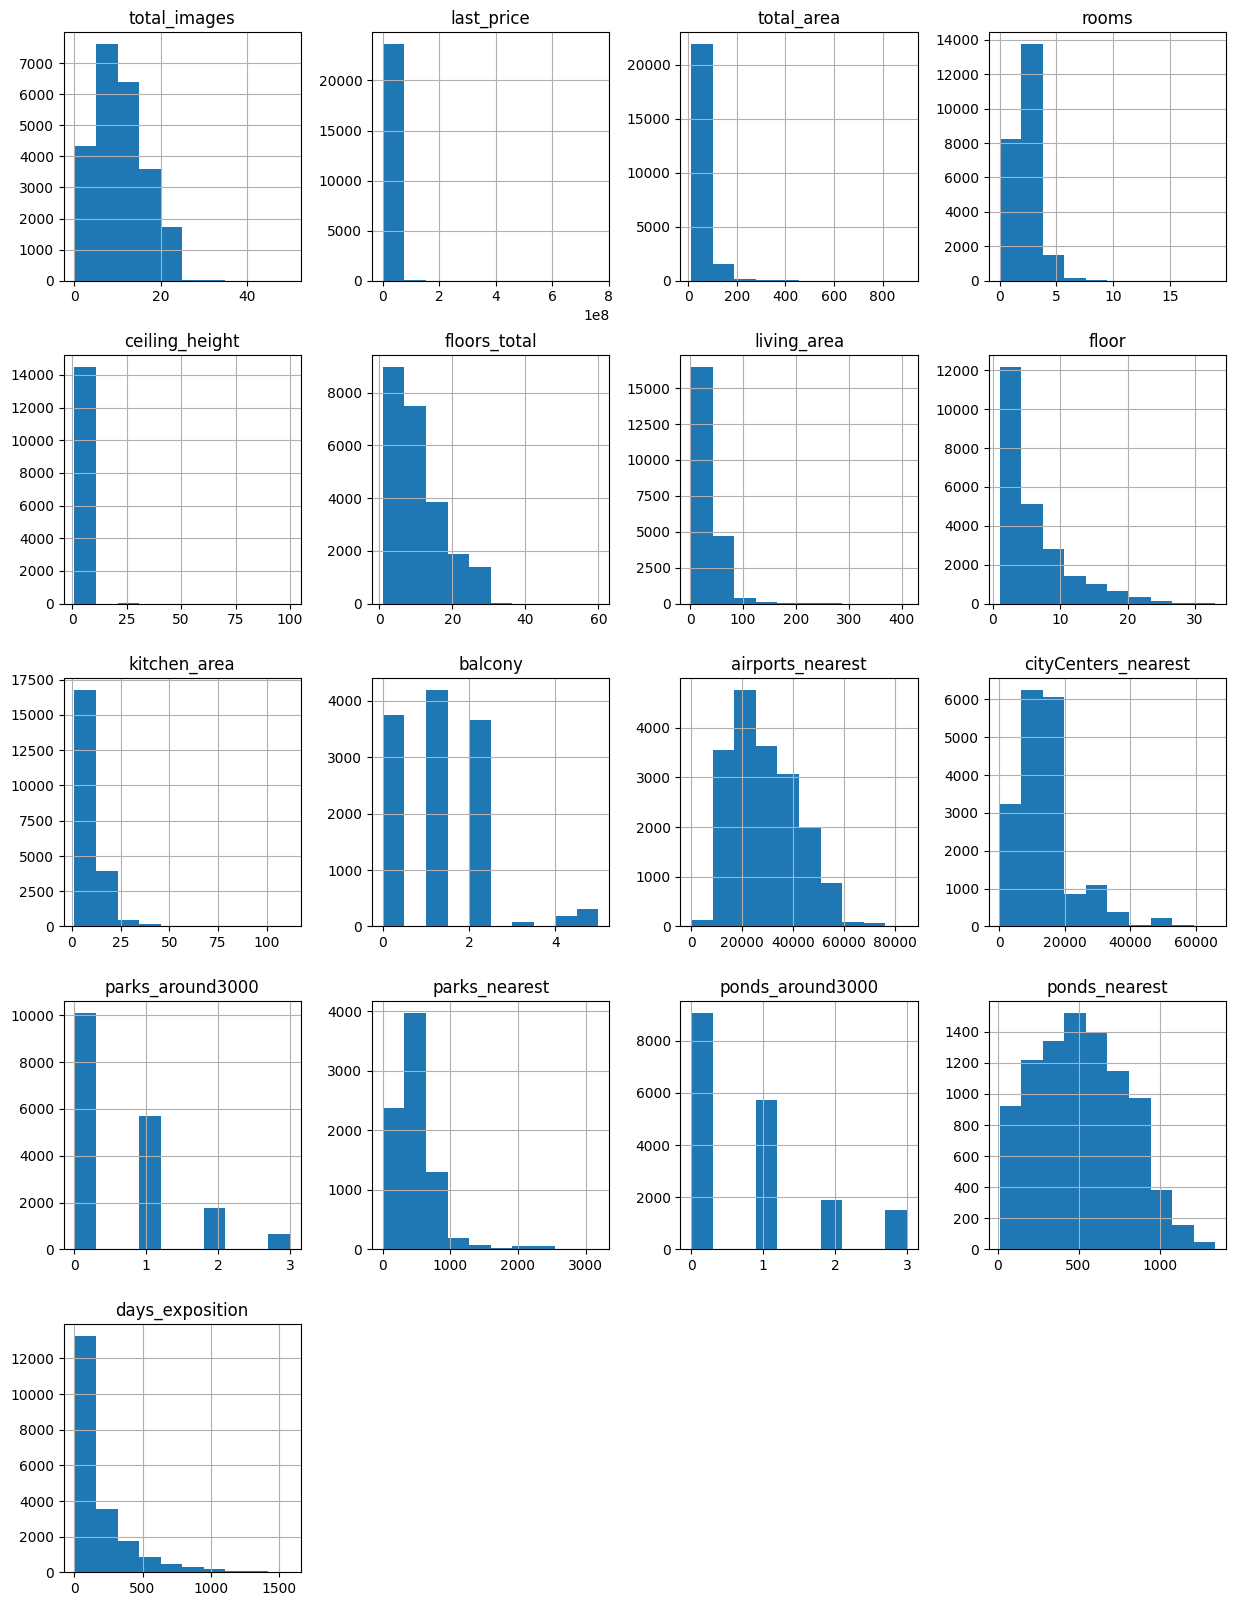

In [5]:
data.hist(figsize=(15,20))
plt.show()

**Вывод:** 

В таблице имеются пропуски данных и различные типы данных в столбцах. В некоторых графиках прослеживается распределение Пуассона. Окончательный вывод по распределению будет сделан после исследовательского анализа данных.

## Предобработка данных

Необходимо будет проверить и заполнить пропуски в данных. Проверить соответствие типов данных, проверить таблицу на дубликаты в каждом столбце и проверить аномальные значения. 

### Поиск дубликатов

Изучим уникальные значения в столбце с названиями и устраните неявные дубликаты. Например, «поселок Рябово» и «поселок городского типа Рябово», «поселок Тельмана» и «посёлок Тельмана» — это обозначения одних и тех же населённых пунктов.

Количество уникальных значений до удаления дубликатов.

In [6]:
len(data['locality_name'].unique())

365

In [7]:
data['locality_name'].value_counts()

Санкт-Петербург     15721
посёлок Мурино        522
посёлок Шушары        440
Всеволожск            398
Пушкин                369
                    ...  
посёлок Шугозеро        1
деревня Кривко          1
деревня Реброво         1
поселок Калитино        1
село Шум                1
Name: locality_name, Length: 364, dtype: int64

In [8]:
data['full_locality_name'] = data['locality_name']
for name in data['locality_name'].sort_values().unique():
    try:
        city_name = name.split(' ')[-1]
        data.loc[data['locality_name'] == name, 'locality_name'] = city_name
    except:
        continue

Количество уникальных значений после удаления дубликатов.

In [9]:
len(data['locality_name'].unique())

295

**Вывод:** Старые названия были записаны в столбец `full_locality_name`, а новые значения без типа населенного пункта сохранены в `locality_name`.

### Поиск пропущенных значений

In [10]:
data.isna().sum()

total_images                0
last_price                  0
total_area                  0
first_day_exposition        0
rooms                       0
ceiling_height           9195
floors_total               86
living_area              1903
floor                       0
is_apartment            20924
studio                      0
open_plan                   0
kitchen_area             2278
balcony                 11519
locality_name              49
airports_nearest         5542
cityCenters_nearest      5519
parks_around3000         5518
parks_nearest           15620
ponds_around3000         5518
ponds_nearest           14589
days_exposition          3181
full_locality_name         49
dtype: int64

В столбцах: 

`ceiling_height`,
`floors_total`, 
`living_area`, 
`is_apartment`, 
`kitchen_area`, 
`balcony`, 
`locality_name`, 
`airports_nearest`,
`cityCenters_nearest`, 
`parks_around3000`, 
`parks_nearest`, 
`ponds_arround3000`, 
`ponds_nearest`, 
`days_exposition`. 

Имеются пропуски

#### Столбец locality_name

Удалим все строчки без названия населенного пункта.


In [11]:
data = data.dropna(subset=['locality_name'])

#### Столбец ceiling_height

Заполним пропуски, все значения больше 10 разделим на 10, чтобы исправить аномальные значения.

In [12]:
data.loc[data['ceiling_height'] >= 10, 'ceiling_height'] /= 10
median = data.pivot_table(index='locality_name',aggfunc='median')
for locality in data['locality_name'].unique():
    ceiling_height = median.loc[locality,'ceiling_height']
    data.loc[(data['ceiling_height'].isna()) & (data['locality_name'] == locality),'ceiling_height'] = ceiling_height

Выставим медианое значение высоты потолков для единичных населенных пунктов, для которых нельзя посчитать медиану.

In [13]:
data.loc[data['ceiling_height'].isna(),'ceiling_height'] = data['ceiling_height'].median()

Проверим итоговые значения.

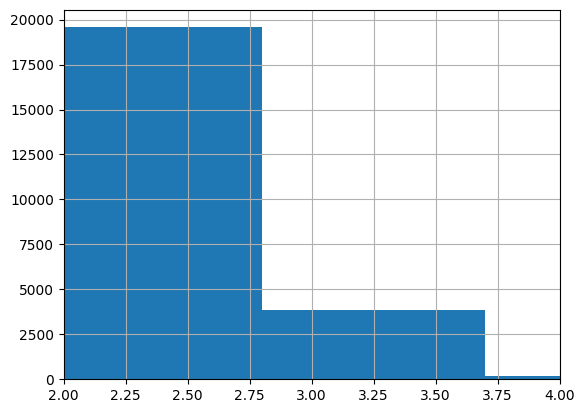

In [14]:
data['ceiling_height'].hist(bins=10)
plt.xlim(2,4)
plt.show()

#### Столбец living_area

Добавим столбец пересчета жилой площади и общей площади.


In [15]:
data['total/living'] = data['total_area'] / data['living_area']

Для единичных населенных пунктов заменим медианым коэффициентом по всем населенным пунктам.

In [16]:
data.loc[data['total/living'].isna(),'total/living'] = data.loc[data['total/living'].isna(),'total_area'] / data['living_area'].median()


Иногда жилая площадь превышает общую площадь, необходимо пересчиать медианым значением.

In [17]:
data.loc[data['total/living'] <= 1, 'total/living'] = data['total/living'].median()
data['living_area'] = data['total_area'] / data['total/living']

Заполним пропуски медианой населенного пункта.

In [18]:
median = data.pivot_table(index='locality_name',aggfunc='median')
for locality in data['locality_name'].unique():
    living_area = (data.loc[data['locality_name'] == locality,'total_area'] / median.loc[locality,'total/living']).median()
    data.loc[(data['locality_name'] == locality) & (data['living_area'].isna()),'living_area'] = living_area

Проверим итоговые значения.

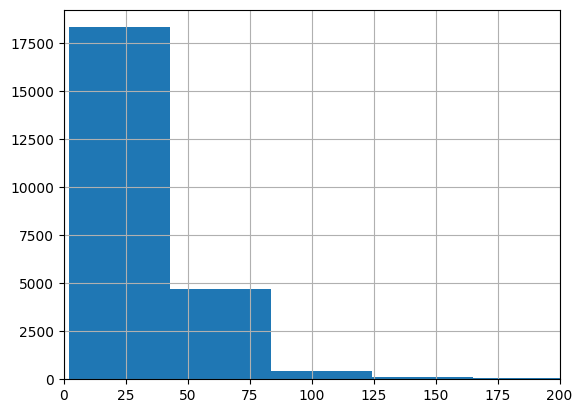

In [19]:
data['living_area'].hist(bins=10)
plt.xlim(0,200)
plt.show()

#### Столбец floors_total

Будем считать, что когда нет значения это максимальный этаж. Изменим значения `NaN` на значение из столбца `floor`.

In [20]:
data.loc[data['floors_total'].isna(),'floors_total'] = data.loc[data['floors_total'].isna(),'floor']

Проверим итоговые значения.

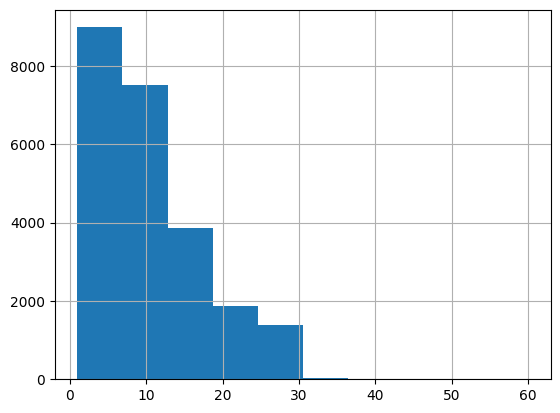

In [21]:
data['floors_total'].hist(bins=10)
plt.show()

#### Столбец is_apartment

Будем считать, что когда нет значения это не апартаменты. Изменим значения `NaN` на значение `False`.

In [22]:
data.loc[data['is_apartment'].isna(),'is_apartment'] = False

Проверим итоговые значения.

In [23]:
data['is_apartment'].value_counts()

False    23600
True        50
Name: is_apartment, dtype: int64

#### Столбец kitchen_area

In [24]:
for locality in data['locality_name'].unique():
    kitchen_area = median.loc[locality,'kitchen_area']
    data.loc[(data['kitchen_area'].isna()) & (data['locality_name'] == locality),'kitchen_area'] = kitchen_area

Выставим медианое значение площади кухни для единичных населенных пунктов, для которых нельзя посчитать медиану.

In [25]:
data.loc[data['kitchen_area'].isna(),'kitchen_area'] = data['kitchen_area'].median()

Проверим итоговые значения.

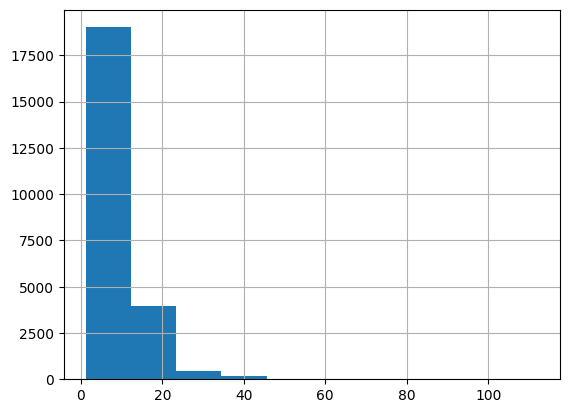

In [26]:
data['kitchen_area'].hist(bins=10)
plt.show()

#### Столбец first_day_exposition

Исправим формат данных в формат даты.

In [27]:
data['first_day_exposition'] = pd.to_datetime(data['first_day_exposition'])

#### Столбец balcony

Если мы не знаем число балкнов, будем считать, что их 0.

In [28]:
data['balcony'] = data['balcony'].fillna(0)

Число балконов должно быть формата `int64`.

In [29]:
data['balcony'] = data['balcony'].astype('int')

Проверим итоговые значения.

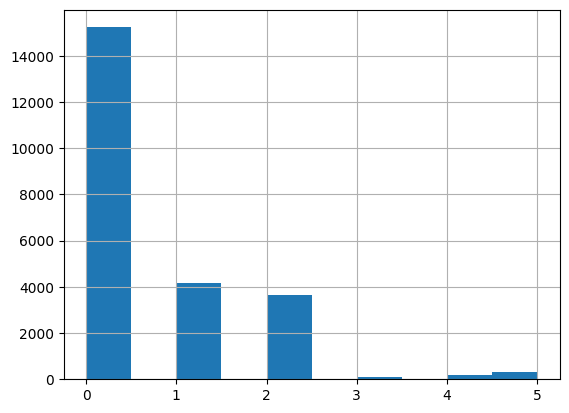

In [30]:
data['balcony'].hist(bins=10)
plt.show()

#### Столбец airports_nearest, cityCenters_nearest, parks_around3000, parks_nearest, ponds_arround3000, ponds_nearest, days_exposition

Пропуски в столбцах менять не будем, так как данные являются картографическими.

### Удаление выбросов.

(0.0, 100.0)

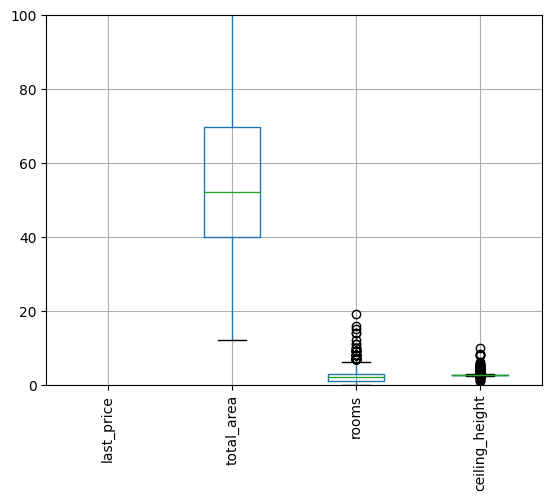

In [31]:
columns = [
    'last_price',
    'total_area',
    'rooms',
    'ceiling_height']
data = data.reset_index(drop=True)
data[columns].boxplot(rot=90)
plt.ylim(0,100)

In [32]:
data.describe()

,total_images,last_price,total_area,rooms,ceiling_height,floors_total,living_area,floor,kitchen_area,balcony,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition,total/living
count,23650.000000,2.365000e+04,23650.000000,23650.000000,23650.000000,23650.000000,23650.000000,23650.000000,23650.000000,23650.000000,18116.000000,18139.000000,18140.000000,8064.000000,18140.000000,9085.000000,20470.000000,23650.000000
mean,9.862326,6.541127e+06,60.329069,2.070106,2.704466,10.673784,34.029806,5.893277,10.464962,0.591712,28803.225878,14197.860742,0.611577,490.830729,0.769680,518.059879,180.753200,1.871200
std,5.682278,1.089640e+07,35.661808,1.078620,0.241924,6.593455,21.204456,4.883317,5.631594,0.959662,12637.314144,8606.830295,0.802003,342.554386,0.937948,277.841733,219.777916,0.678047
min,0.000000,1.219000e+04,12.000000,0.000000,1.000000,1.000000,2.000000,1.000000,1.300000,0.000000,0.000000,181.000000,0.000000,1.000000,0.000000,13.000000,1.000000,1.003333
25%,6.000000,3.400000e+06,40.000000,1.000000,2.550000,5.000000,19.000000,2.000000,7.200000,0.000000,18575.750000,9241.000000,0.000000,288.000000,0.000000,293.000000,45.000000,1.560000
50%,9.000000,4.650000e+06,52.000000,2.000000,2.700000,9.000000,30.000000,4.000000,9.600000,0.000000,26756.500000,13105.000000,0.000000,454.500000,1.000000,502.000000,95.000000,1.761102
75%,14.000000,6.799000e+06,69.700000,3.000000,2.700000,16.000000,41.037500,8.000000,11.447500,1.000000,37294.000000,16293.000000,1.000000,612.000000,1.000000,730.000000,231.000000,2.036646
max,50.000000,7.630000e+08,900.000000,19.000000,10.000000,60.000000,409.700000,33.000000,112.000000,5.000000,84869.000000,65968.000000,3.000000,3190.000000,3.000000,1344.000000,1580.000000,46.333333


Обратите внимание, что среднее почти в два раза больше медианы. Значит, в распределении есть длинный хвост с высокими значениями или несколько очень больших значений.

Удалим значения не удовлетворяющие условию.

In [33]:
columns = [
    'last_price',
    'total_area',
    'rooms',
    'ceiling_height']

In [34]:
for column_name in columns:
    if column_name == 'last_price':
        new_data = data.query(f'{column_name} <= 15000000')
    elif column_name == 'total_area':
        new_data = new_data.query(f'{column_name} <= 100')
    elif column_name == 'rooms':
        new_data = new_data.query(f'0 < {column_name} <= 10')
    elif column_name == 'ceiling_height':
        new_data = new_data.query(f'2 < {column_name} <= 4')
    else:
        print(column_name)
        continue
    new_data = new_data.reset_index(drop=True)
    print(new_data.shape[0] / data.shape[0],column_name)


0.9492600422832981 last_price
0.9130232558139535 total_area
0.9047780126849895 rooms
0.9030021141649048 ceiling_height


Построим графики для всех столбцов таблицы.

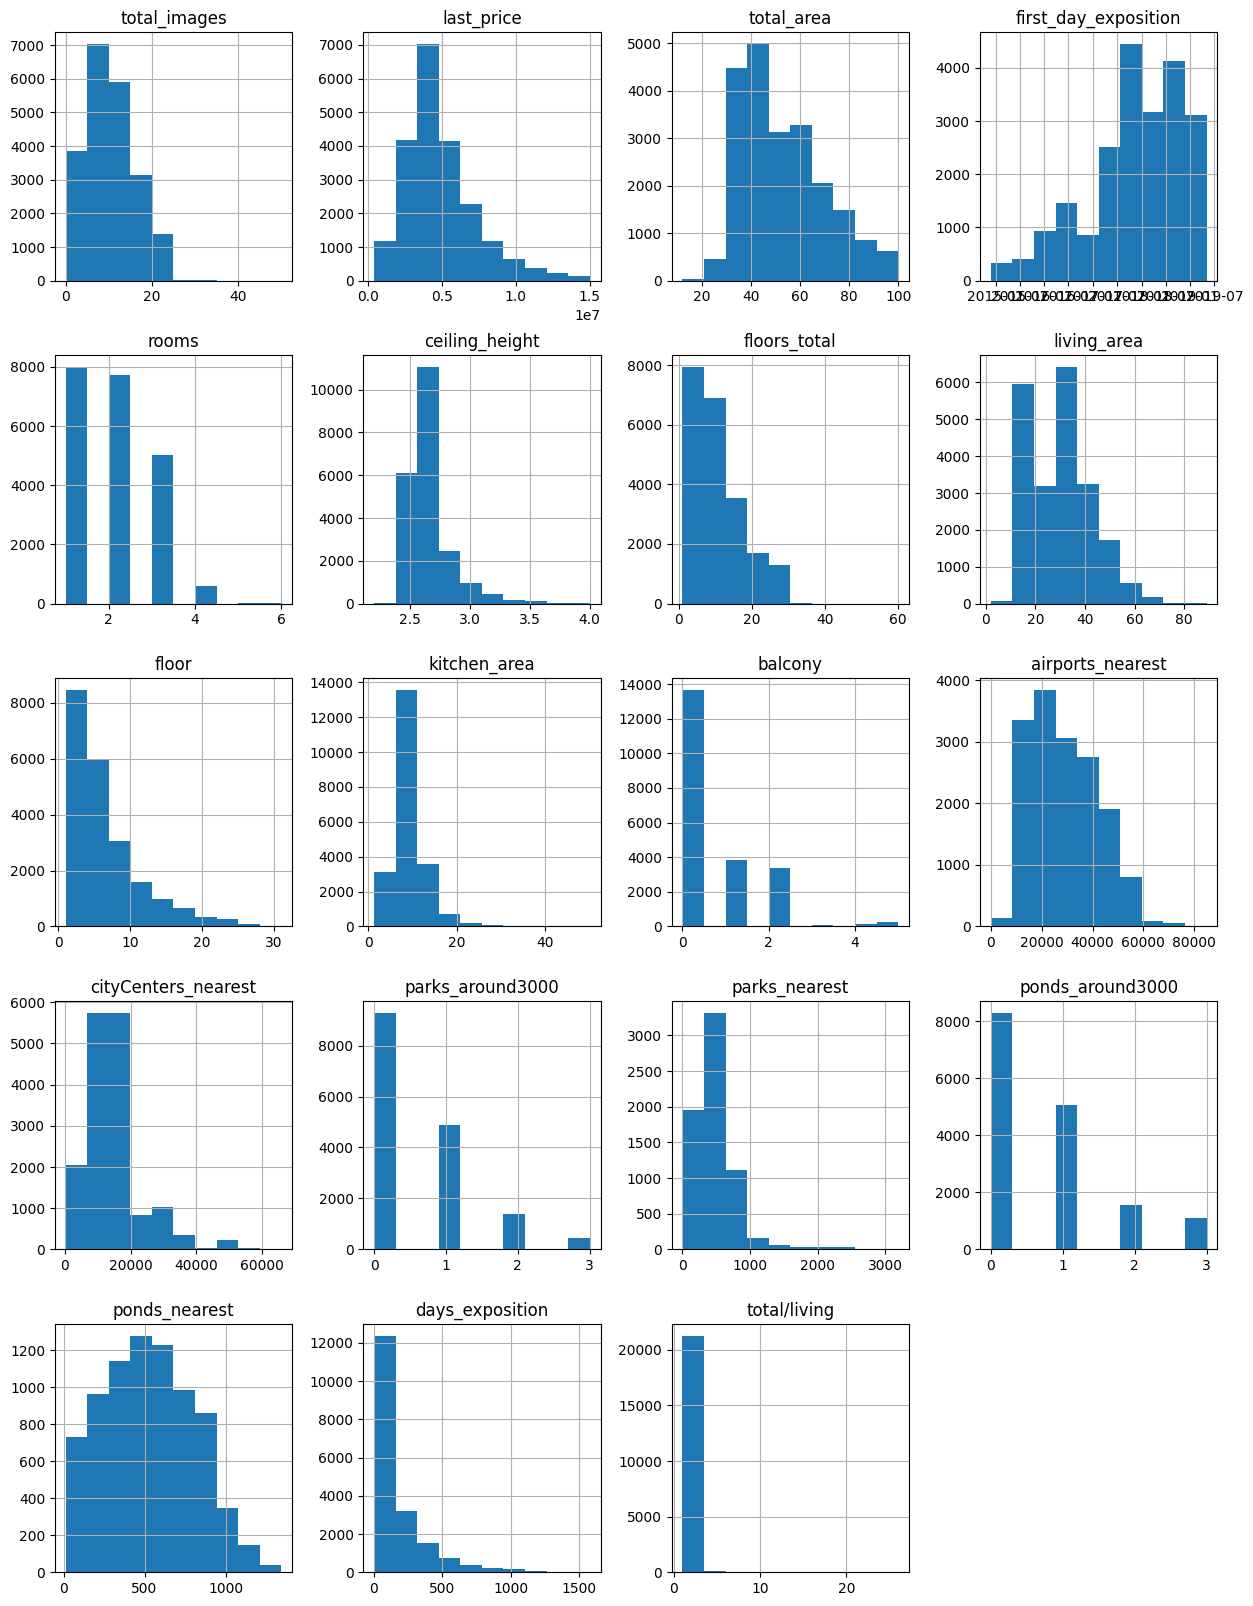

In [35]:
new_data.hist(figsize=(15,20))
plt.show()

(2.0, 3.0)

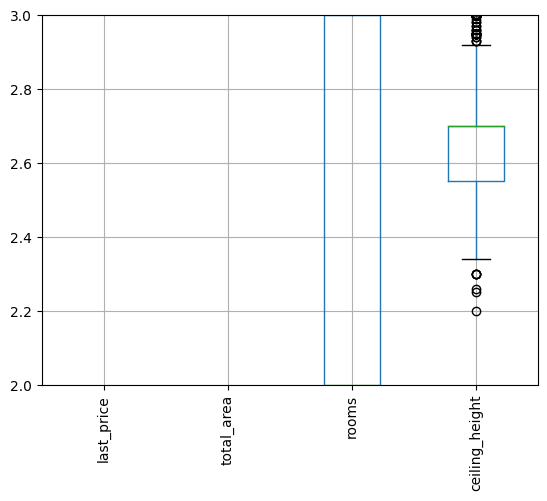

In [36]:
 columns = [
    'last_price',
    'total_area',
    'rooms',
    'ceiling_height']
new_data[columns].boxplot(rot=90)
plt.ylim(2,3)

In [37]:
new_data.shape[0] / data.shape[0]

0.9030021141649048

**Вывод:**
- Были удалены дубликаты названий и создан отдельный столбец для них.
- Были исправлены типы данных.
- Все пустые значения были заменены медианным значением для каждого населенного пункта.
- Были удалены значения выбросов для столбцов 'last_price',
    'total_area',
    'rooms',
    'ceiling_height' методом IQR. От начальных данных осталось 90,37%


## Обработка данных

Добавим столбец цена за квадратный метр.

In [38]:
new_data['price_area'] = (new_data['last_price'] / new_data['total_area']).round()

Добавим столбец день публикации объявления (0 - понедельник, 1 - вторник и т.д.).

In [39]:
new_data['day']=new_data['first_day_exposition'].dt.dayofweek

Добавим столбец месяц публикации объявления.

In [40]:
new_data['month']=new_data['first_day_exposition'].dt.month

Добавим столбец год публикации объявления.

In [41]:
new_data['year']=new_data['first_day_exposition'].dt.year

Добавим столбец тип этажа квартиры (значения — «первый», «последний», «другой»)

Создадим функцию для проверки каждой строчки в датафрейме.

In [42]:
def check_floor(row):
    try:
        if row['floor'] == 1:
            return 'первый'
        elif row['floor'] == row['floors_total']:
            return 'последний'
        else:
            return 'другой'
    except:
        return 'другой'

Добавим столбец

In [43]:
new_data['floor_type'] = new_data.apply(check_floor,axis=1)

Добавим столбец расстояние в км до центра города.

In [44]:
new_data['cityCenters_nearest_km'] = (new_data['cityCenters_nearest'].astype('Int64') / 1000).astype('Int64')

## Исследовательский анализ данных

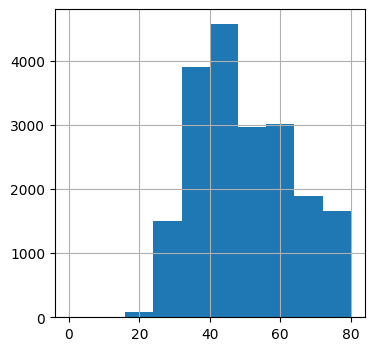

In [45]:
new_data['total_area'].hist(figsize=(4,4),range=(0,80))
plt.show()

Больше всего квартир с площадью 30-50 квадратных метров.

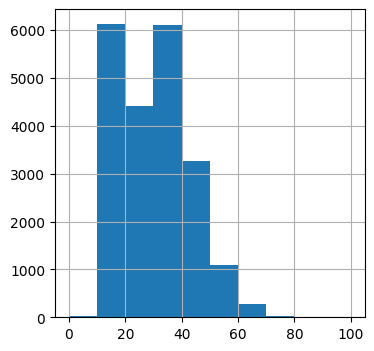

In [46]:
new_data['living_area'].hist(figsize=(4,4),range=(0,100))
plt.show()

Больше всего квартир с жилой площадью от 15 до 20 и от 30 до 40.

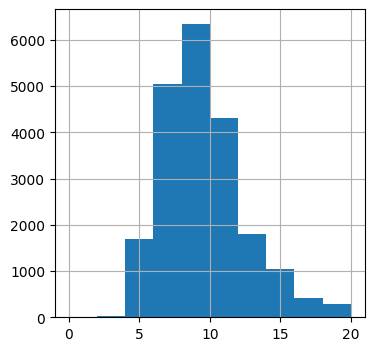

In [47]:
new_data['kitchen_area'].hist(figsize=(4,4),range=(0,20))
plt.show()

Больше всего квартир с площадью кухни около 10 метров.

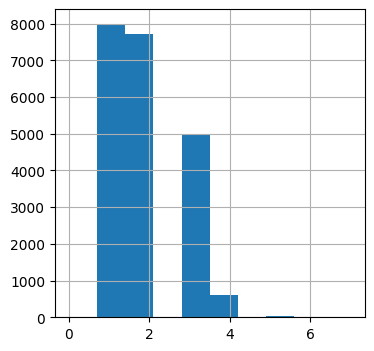

In [48]:
new_data['rooms'].hist(figsize=(4,4),range=(0,7))
plt.show()

Больше всего квартир с количеством комнат от 1 до 2 и от 3 до 4.

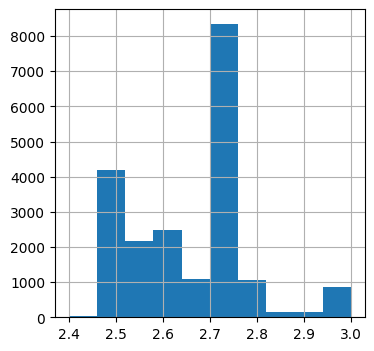

In [49]:
new_data['ceiling_height'].hist(figsize=(4,4),range=(2.4,3))
plt.show()

Больше всего квартир с высотой потолка 2.7

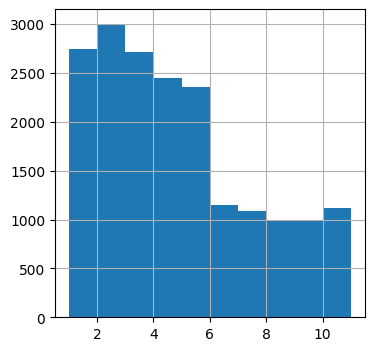

In [50]:
new_data['floor'].hist(figsize=(4,4),range=(1,11))
plt.show()

Больше всего квартир расположено на 2 этаже.

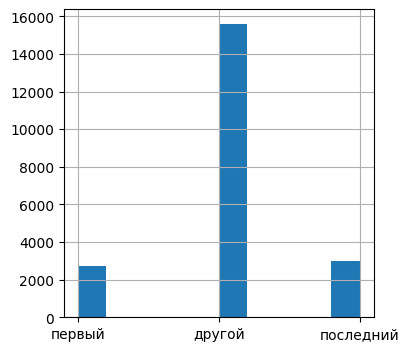

In [51]:
new_data['floor_type'].hist(figsize=(4,4))
plt.show()

Больше всего квартир расположено не на первом и не на последнем этаже.

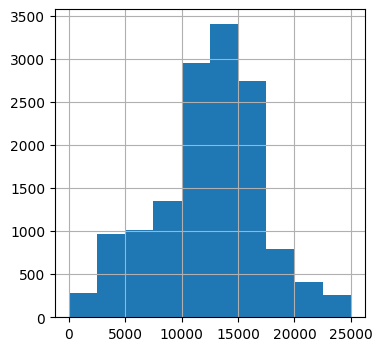

In [52]:
new_data['cityCenters_nearest'].hist(figsize=(4,4),range=(0,25000))
plt.show()

Больше всего квартир с расстоянием до центра города 10-20 км.

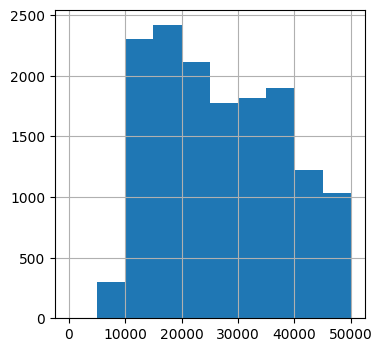

In [53]:
new_data['airports_nearest'].hist(figsize=(4,4),range=(0,50000))
plt.show()

Больше всего квартир с расстоянием до аэропорта 10-20 км


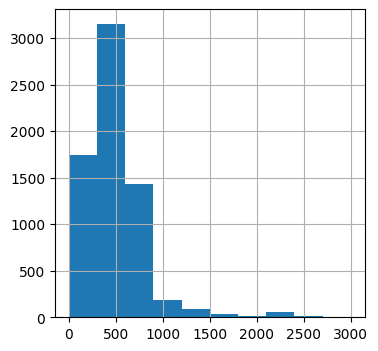

In [54]:
new_data['parks_nearest'].hist(figsize=(4,4),range=(0,3000))
plt.show()

Больше всего квартир с расстоянием до парка около 500 метров.

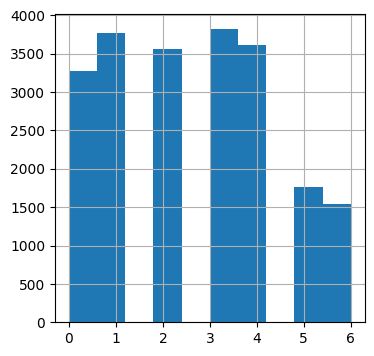

In [55]:
new_data['day'].hist(figsize=(4,4),range=(0,6))
plt.show()

Больше всего квартир, которые публикуют на продажу в будни.

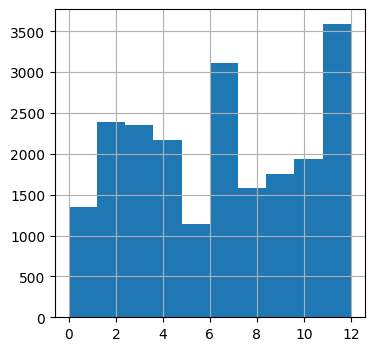

In [56]:
new_data['month'].hist(figsize=(4,4),range=(0,12))
plt.show()

Больше всего квартир, которые публикуют в конце или середине года.

**Вывод**: 

Больше всего квартир:
- с площадью 30-50 квадратных метров.
- с жилой площадью от 15 до 20 и от 30 до 40.
- с площадью кухни 10.
- в ценовом диапазоне 3-4 млна.
- с количеством комнат от 1 до 2 и от 3 до 4.
- с высотой потолка 2.7
- расположено на 2-3 этаже.
- расположено не на первом и не на последнем этаже.
- с расстоянием до центра города 10-20 км
- с расстоянием до аэропорта 10-20 км
- с расстоянием до парка около 500 метров
- которые публикуют на продажу в будни
- которые публикуют в конце или середине года.

### Изучим cкорость продажи квартир.

(0.0, 300.0)

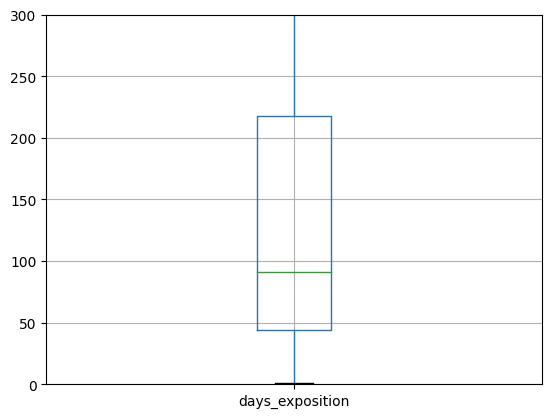

In [57]:
new_data.boxplot('days_exposition')
plt.ylim(0,300)

Получим значения среднего и медиану.

In [58]:
new_data['days_exposition'].describe()

count    18711.000000
mean       172.654054
std        211.228513
min          1.000000
25%         44.000000
50%         91.000000
75%        218.000000
max       1580.000000
Name: days_exposition, dtype: float64

**Вывод:** 

В среднем продажа занимает 91 дня, быстрой продажей считается если продали быстрее чем за 44 дней. Медленной считается продажа больше чем за 218 дней.

### Факторы, которые больше всего влияют на стоимость объекта.

In [59]:
columns = [
    'total_area',
    'living_area',
    'kitchen_area',
    'rooms'
]

price vs total_area corr 0.6941224755768608
price vs living_area corr 0.5229809947932005
price vs kitchen_area corr 0.48513147834008863
price vs rooms corr 0.403871888699511


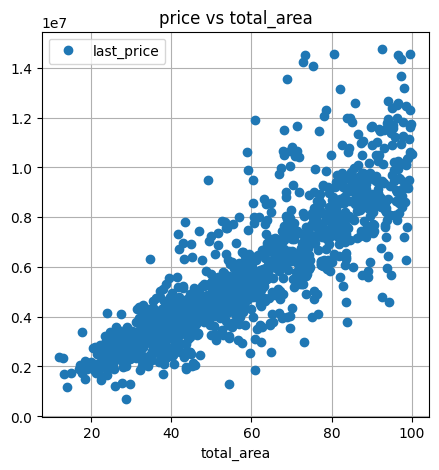

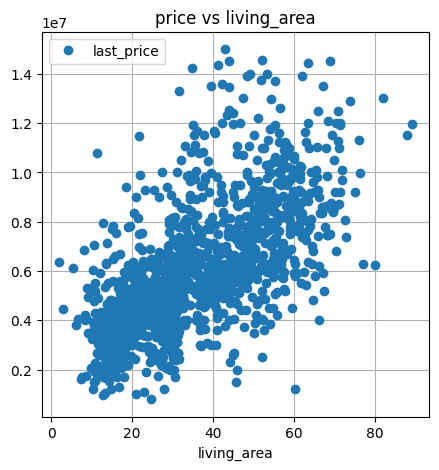

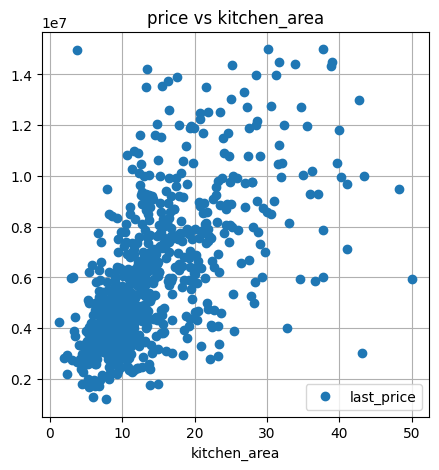

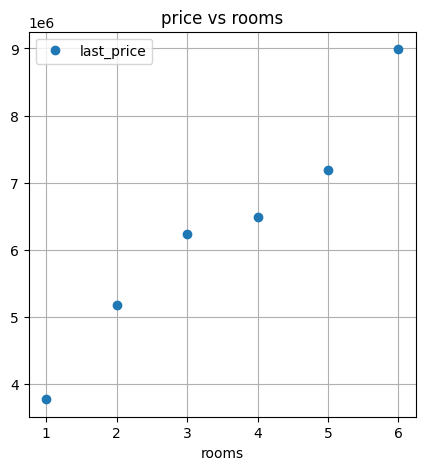

In [60]:
for column_name in columns:
    
    (new_data.pivot_table(index=column_name,values='last_price')
    .plot(grid=True,style='o',figsize=(5,5))
    )
    print(f'price vs {column_name} corr',new_data['last_price'].corr(new_data[column_name]))
    plt.title(f'price vs {column_name}')
plt.show()

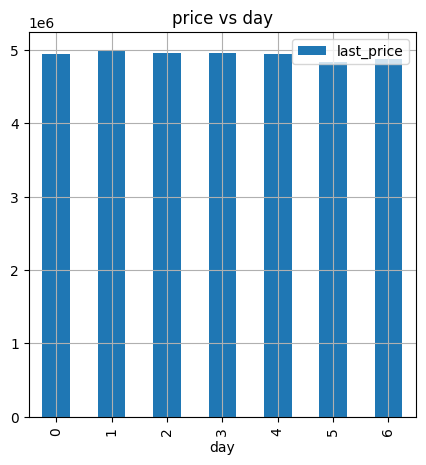

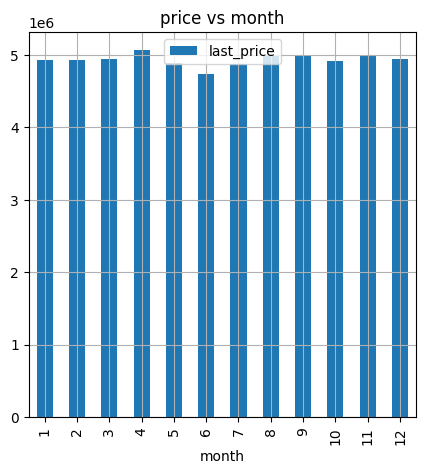

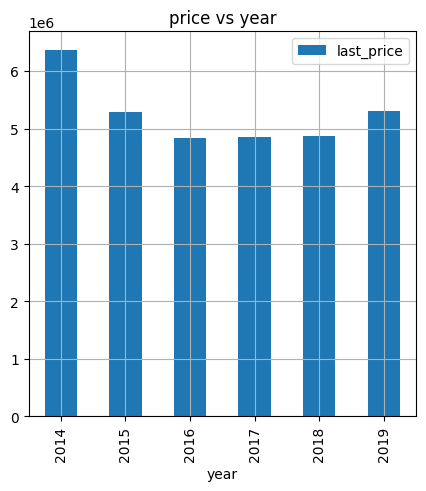

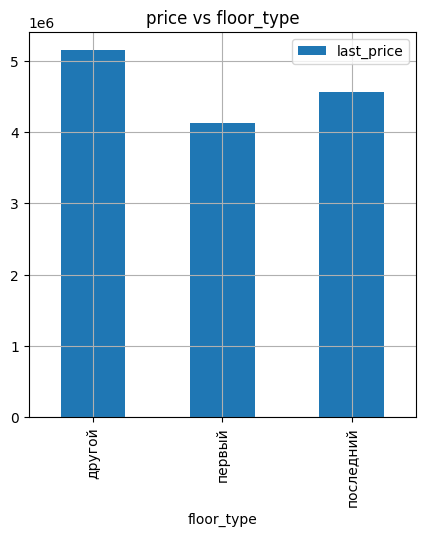

In [61]:
columns = [
    'day',
    'month',
    'year',
    'floor_type'
]

for column_name in columns:
    (new_data.pivot_table(index=column_name,values='last_price')
    .plot(grid=True,kind='bar',figsize=(5,5))
    )
    plt.title(f'price vs {column_name}')
plt.show()

**Вывод:**
Цена больше всего зависит от общей площади, жилой площади, площади кухни, количество комнат. Остальные показатели не коррелируют с ценой. Самая низкая цена в среднем на квартиры на первом этаже. Цена квартир с 2014 по 2018 падала, с 2019 начался рост.

### Населенные пункты с наибольшим числом объявлений.

Посчитаем среднюю цену одного квадратного метра в 10 населённых пунктах с наибольшим числом объявлений.

In [62]:
new_data.groupby('locality_name').agg({'total_images' : 'count','price_area' : 'mean'})\
    .rename(columns= {'total_images' : 'Число объявлений'})\
    .sort_values(by='Число объявлений',ascending=False)\
    .head(10)


,Число объявлений,price_area
locality_name,,
Санкт-Петербург,13694,107573.748138
Мурино,561,85456.114082
Кудрово,448,95110.410714
Шушары,427,78511.887588
Всеволожск,384,67133.476562
Пушкин,338,101180.701183
Колпино,332,75322.225904
Парголово,320,90613.471875
Гатчина,301,68938.421927


**Вывод:** Самая дорогая цена за квадратный метр в Санкт-Петербурге, а самая маленькая в Выборге (среди населенных пунктов с наибольшим числом объявлений.

### Как стоимость объектов зависит от расстояния до центра города

Ранее мы посчитали расстояние до центра в километрах. Теперь выделите квартиры в Санкт-Петербурге с помощью столбца locality_name и вычислите среднюю цену каждого километра.

-0.3508454619004728

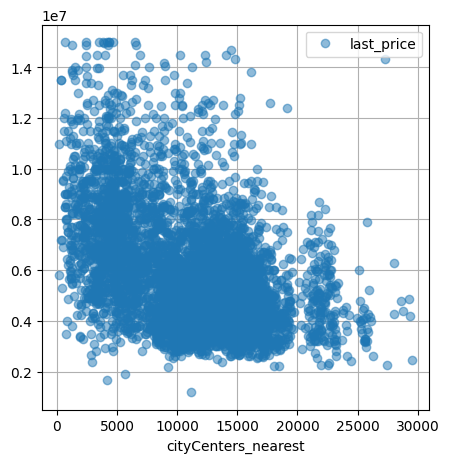

In [63]:
new_data.loc[new_data['locality_name'] == 'Санкт-Петербург'].pivot_table(index='cityCenters_nearest',values='last_price',aggfunc='mean') \
    .plot(grid=True,style='o',figsize=(5,5),alpha=0.5)
new_data['last_price'].corr(new_data['cityCenters_nearest'])

<AxesSubplot:>

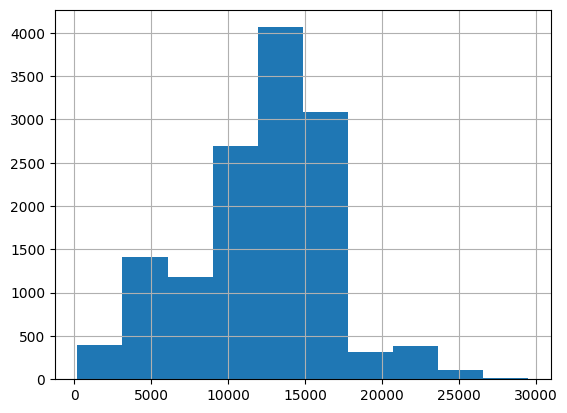

In [64]:
new_data.loc[new_data['locality_name'] == 'Санкт-Петербург']['cityCenters_nearest'].hist()

**Вывод:** 

Чем дальше от центра тем ниже цена, но не всегда квартира в центре города дорогая.

# Общий вывод

**Была проведена обработка данных:**
* Были удалены дубликаты названий и создан отдельный столбец для них.
* Были исправлены типы данных.
* Все пустые значения были заменены медианым значением для каждого населенного пункта.
* Были удалены значения выбросов для столбцов `last_price`, `total_area`, `rooms`, `ceiling_height`, `floors_total`, `living_area`, `floor`, `kitchen_area`, `balcony`, `days_exposition` методом IQR.

**Было проведено исследование данных:**

Больше всего квартир:
- с площадью 30-50 квадратных метров.
- с жилой площадью от 15 до 20 и от 30 до 40.
- с площадью кухни 10.
- в ценовом диапазоне 3-4 млна.
- с количеством комнат от 1 до 2 и от 3 до 4.
- с высотой потолка 2.7
- расположено на 2-3 этаже.
- расположено не на первом и не на последнем этаже.
- с расстоянием до центра города 10-20 км
- с расстоянием до аэропорта 10-20 км
- с расстоянием до парка около 500 метров
- которые публикуют на продажу в будни
- которые публикуют в конце или середине года.


**Выводы по данным:**

В среднем продажа занимает 91 дня, быстрой продажей считается если продали быстрее чем за 44 дней. Медленной считается продажа больше чем за 218 дней.

Цена больше всего зависит от общей площади, жилой площади, площади кухни, количество комнат. Остальные показатели не коррелируют с ценой. Самая низкая цена в среднем на квартиры на первом этаже. В 2018 году квартиры начали дорожать.

Самая дорогая цена за квадратный метр в Санкт-Петербурге, а самая маленькая в Выборге (среди населенных пунктов с наибольшим числом объявлений.

Чем дальше от центра тем ниже цена, но не всегда квартира в центре города дорогая.
